In [ ]:
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [9]:
def draw_ellipse(ax, mean, cov, n_std):
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)

    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(*mean)

    ellipse.set_transform(transf + ax.transData)
    return ellipse

In [43]:
class Covariance:
    def __init__(self, angle=0, scale=0.05, width_to_height_ratio=1):
        """
        Angle is in degrees: [0, 180)
        """
        
        width_height = np.array([1, width_to_height_ratio])
        scaled_wh = width_height / np.linalg.norm(width_height) * scale ** 2
        cov = np.diag(scaled_wh)
        
        theta = np.radians(angle)
        c, s = np.cos(theta), np.sin(theta)

        rotation = np.array(((c, -s), (s, c)))

        self.cov = rotation @ cov @ rotation.T

In [ ]:
class Sensor:
    def __init__(self, noise_model):
        self.noise = noise_model
    
    def measure(self, point):
        measurement = np.random.multivariate_normal(point, self.noise, check_valid="raise")
        return (measurement, self.noise)

In [132]:
class AgentConfig:
    def __init__(self, noise: Covariance):
        self.noise = noise.cov

    def sample(self):
        return [(np.random.multivariate_normal([0, 0], self.noise), self.noise)]

# Simple class to simulate a Sybil Attacker
class SybilAttackerConfig:
    def __init__(self, target, noise: Covariance, spread: Covariance, claimed_covariances: List[Covariance]):
        self.target = target #(x, y) location of attack
        self.noise = noise.cov # Underlying sensor noise
        self.spread = spread.cov # How spread out the attack will be
        self.n = len(claimed_covariances)
        self.claimed_covariances = [cov.cov for cov in claimed_covariances]

    def sample(self):
        measurements = []
        measurement = np.random.multivariate_normal(self.target, self.noise)
        for i in range(self.n):
            target_offset = np.random.multivariate_normal([0, 0], self.spread, check_valid="raise")
            measurements.append((measurement + target_offset, self.claimed_covariances[i]))
        return measurements


class Config:
    def __init__(self, good, bad):
        self.good = good
        self.bad = bad

    def _sample_subset(self, subset):
        measurements = []
        for agent in subset:
            measurements += agent.sample()
        return measurements

    def _sample_good(self):
        return self._sample_subset(self.good)
    
    def _sample_bad(self):
        return self._sample_subset(self.bad)

    def sample(self):
        return self._sample_good() + self._sample_bad()

def _summarise_sample(sample):
    total_precision = np.zeros((2, 2))
    total_information = np.zeros((2,))
    for (mu, cov) in sample:
        precision = np.linalg.inv(cov)
        information = precision @ mu

        total_precision += precision
        total_information += information
    
    cov = np.linalg.inv(total_precision)
    mu = cov @ total_information
    return mu, cov


def _kl_divergence(mu_x, sigma_x, mu_y, sigma_y):
    trace = np.trace(np.linalg.inv(sigma_y).dot(sigma_x))
    diff = mu_y - mu_x
    middle_bit = np.linalg.multi_dot([diff.T, np.linalg.inv(sigma_y), diff]) -2
    log = np.log(np.linalg.det(sigma_y)/np.linalg.det(sigma_x))
    return (trace + middle_bit + log) / 2

class Evaluator:
    def __init__(self, n_samples):
        self.n_samples = n_samples

    def _eval_sample(self, sample):
        mu, cov = _summarise_sample(sample)
        return _kl_divergence(np.zeros((2,)), Covariance().cov, mu, cov)


    def evaluate(self, cfg: Config):
        mean_deviation = 0

        for _ in range(self.n_samples):
            sample = cfg.sample()
            deviation = self._eval_sample(sample)
            mean_deviation += deviation
        
        return mean_deviation / self.n_samples    

In [133]:
class Visualiser:
    def __init__(self, gaussian_spread):
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(1, 1, 1)
        self.gaussian_spread = gaussian_spread

    def draw_cfg_sample(self, cfg):
        good = cfg._sample_good()
        self._draw_samples(good, "blue")
        bad = cfg._sample_bad()
        self._draw_samples(bad)

        mu, cov = _summarise_sample(good + bad)
        self._draw_samples([(mu, cov)], "green")
        

    def _draw_samples(self, samples, colour="red"):
        for (mu, cov) in samples:
            for i in range(self.gaussian_spread):
                ellipse = draw_ellipse(self.ax, mu, cov, i+1)
                ellipse.set_alpha(0.2)
                ellipse.set_facecolor(colour)
                self.ax.add_patch(ellipse)

    def show(self):
        plt.xlim([-1, 1])
        plt.ylim([-1, 1])
        plt.gca().set_aspect('equal', adjustable='datalim')
        plt.show()


93.76200075753846


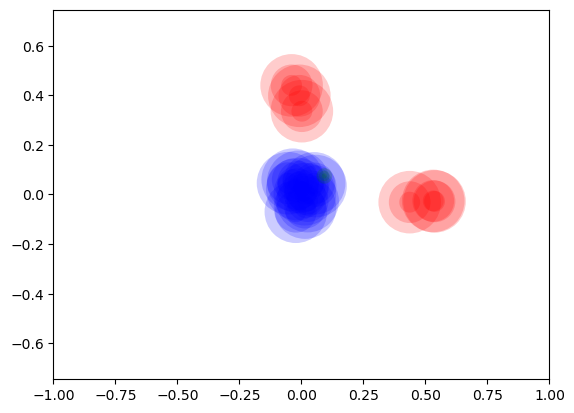

In [151]:
ev = Evaluator(100)

good = [
    AgentConfig(Covariance(scale=0.05)) for _ in range(10)
]

bad = [
    SybilAttackerConfig((0.5, 0), Covariance(), Covariance(), [
        Covariance(scale=0.05),
        Covariance(scale=0.05), 
        Covariance(scale=0.05),
    ]),
    SybilAttackerConfig((0, 0.5), Covariance(), Covariance(), [
        Covariance(scale=0.05),
        Covariance(scale=0.05), 
        Covariance(scale=0.05),
    ])
]

cfg = Config(good, bad)

print(ev.evaluate(cfg))
vis = Visualiser(3)
vis.draw_cfg_sample(cfg)
vis.show()